# Ensemble 

this is the exercise of ensemble method, copy from [Introduction to python ensemble](https://www.dataquest.io/blog/introduction-to-ensembles/)

In [1]:
import os     

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
# import data , 
SEED = 222 
np.random.seed(SEED)

df = pd.read_csv('input.csv')

In [5]:
## training test set 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [6]:
def get_train_test(test_size=0.95):
    '''split data into train/test sets'''
    y = 1*(df.cand_pty_affiliation =='REP')
    X = df.drop(['cand_pty_affiliation'], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

## 
print("\nExample Data:")
df.head()


Example Data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [7]:
df.cand_pty_affiliation.value_counts(normalize=True)

DEM    0.75608
REP    0.24392
Name: cand_pty_affiliation, dtype: float64

### DecisionTreeClassifier

In [8]:
# !pip install pydotplus ## install pydotplus 

In [9]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [10]:
def print_graph(clf, feature_names):
    '''print decision tree'''
    graph = export_graphviz(
        clf,
        label='root',
        proportion=True,
        out_file=None,
        feature_names=feature_names,
        class_names={0:'D',1:'R'},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

In [13]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:,1]
print('Decision tree ROC-AUC score: {:.3f}'.format(roc_auc_score(ytest,p)))

Decision tree ROC-AUC score: 0.672


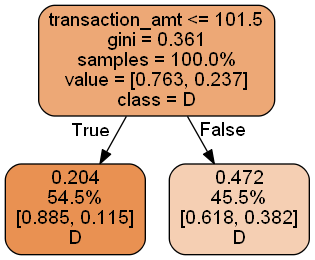

In [14]:
print_graph(t1,xtrain.columns)

In [12]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:,1]

print('Decision tree ROC-AUC score:{:.3f}'.format(roc_auc_score(ytest,p)))

Decision tree ROC-AUC score:0.751


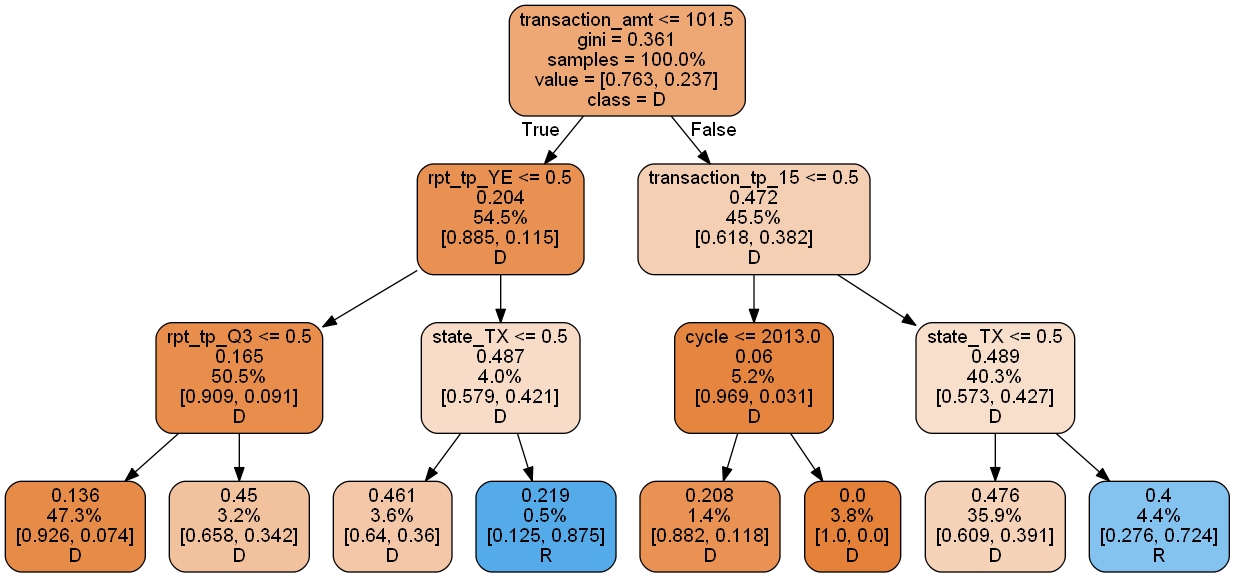

In [15]:
print_graph(t2, xtrain.columns)

Decision tree ROC-AUC score: 0.740


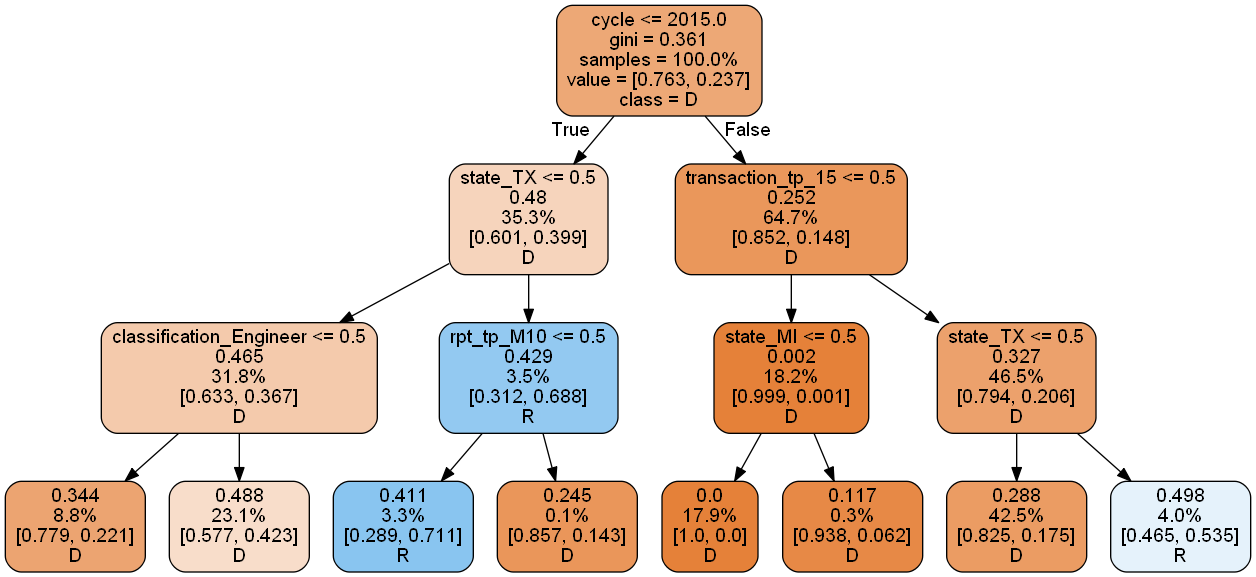

In [16]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

In [17]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


In [18]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))


Average of decision tree ROC-AUC score: 0.844


# To build an ensemble of various model

In [22]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [21]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [23]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
random forest... done
knn... done
gbm... done
naive bayes... done
logistic... done
mlp-nn... done
svm... done
Done.

Scoring models.
random forest             : 0.844
knn                       : 0.779
gbm                       : 0.878
naive bayes               : 0.803
logistic                  : 0.857
mlp-nn                    : 0.851
svm                       : 0.850
Done.



In [31]:
P.head()

,random forest,knn,gbm,naive bayes,logistic,mlp-nn,svm
0,0.3,0.333333,0.265998,5.020798e-10,0.149802,0.156115,0.345439
1,0.0,0.000000,0.017165,1.085367e-68,0.002533,0.010601,0.007051
2,0.2,0.333333,0.328002,6.701134e-14,0.284235,0.226278,0.557809
3,0.0,0.000000,0.024914,2.862588e-62,0.024563,0.049854,0.043589
4,0.0,0.000000,0.017396,1.020511e-61,0.004619,0.027849,0.004205


In [34]:
P.corr()

,random forest,knn,gbm,naive bayes,logistic,mlp-nn,svm
random forest,1.000000,0.621119,0.777899,0.445388,0.733332,0.700009,0.708069
knn,0.621119,1.000000,0.645926,0.332933,0.560337,0.593919,0.705395
gbm,0.777899,0.645926,1.000000,0.533438,0.868336,0.874511,0.781459
naive bayes,0.445388,0.332933,0.533438,1.000000,0.594652,0.551825,0.454312
logistic,0.733332,0.560337,0.868336,0.594652,1.000000,0.805134,0.742293
mlp-nn,0.700009,0.593919,0.874511,0.551825,0.805134,1.000000,0.735187
svm,0.708069,0.705395,0.781459,0.454312,0.742293,0.735187,1.000000


In [35]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


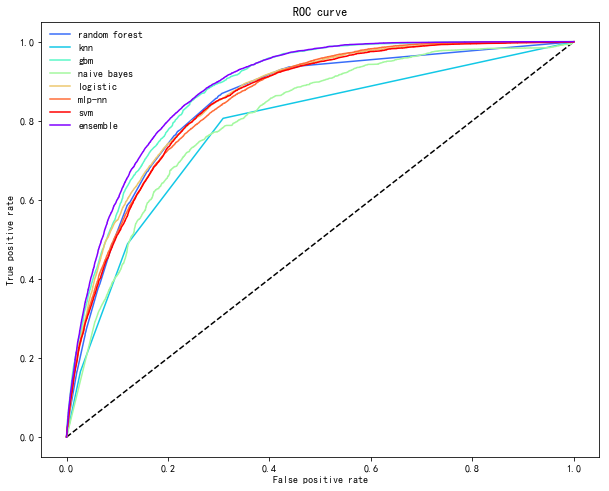

In [36]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")
